In [38]:
from notebook_utils import resolve_paths_from_parent_directory
resolve_paths_from_parent_directory()
# auto reload notebook deps
%reload_ext autoreload
%autoreload 2

Successfully loaded Twitter API keys
Successfully loaded Twitter API keys


In [39]:
import pandas as pd

df_celeb_raw = pd.read_csv("../data/celebrity/Top-1000-Celebrity-Twitter-Accounts.csv")

In [40]:
df_celeb_raw

,twitter,domain,name,type
0,katyperry,katyperry.com,KATY PERRY,celebrity
1,justinbieber,smarturl.it,Justin Bieber,celebrity
2,taylorswift13,grmypro.co,Taylor Swift,celebrity
3,rihanna,rihannanow.com,Rihanna,celebrity
4,ladygaga,NaN,The Countess,celebrity
...,...,...,...,...
991,Zedd,smarturl.it,Zedd,celebrity
992,SleepintheGardn,katuriankaturiankaturian.tumblr.com,Troian,celebrity
993,therealjuicyj,thejuicyj.com,juicy j,celebrity
994,manugavassi,manugavassi.com.br,Manu Gavassi,celebrity


In [6]:
from api.twitter import fetch_users
import numpy as np
import math

user_data = []
errors = []
for handle_chunk in np.array_split(
    df_celeb_raw.twitter, 
    math.ceil(df_celeb_raw.shape[0] / 100)
):
    resp = fetch_users(handle_chunk)
    user_data += resp["data"]
    errors += resp["errors"]

Successfully loaded Twitter API keys


2021-10-20 15:17:43.632 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:43.970 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:44.439 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:44.782 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:45.140 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:45.488 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:45.849 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:46.172 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:46.853 INFO    root: GET request to https://api.twitter.com/2/users/by, response 200
2021-10-20 15:17:47.172 INFO    root: GET request to https://api.twitter.com/2/use

In [7]:
df_celeb = df_celeb_raw.rename(
    columns={"twitter": "twitter_username"}
)
user_data_by_username = {user["username"]: user for user in user_data}

# remove rows that are missing data
df_celeb = df_celeb[df_celeb.twitter_username.apply(lambda u: u in user_data_by_username)]

len(df_celeb)

939

In [8]:
user_data[0]

{'description': 'Love. Light.',
 'public_metrics': {'followers_count': 108789024,
  'following_count': 236,
  'tweet_count': 11460,
  'listed_count': 128752},
 'name': 'KATY PERRY',
 'verified': True,
 'id': '21447363',
 'created_at': '2009-02-20T23:45:56.000Z',
 'username': 'katyperry'}

In [9]:
df_celeb["followers_count"] = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["public_metrics"]["followers_count"]
)
df_celeb["user_tweet_count"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["public_metrics"]["tweet_count"]
)
df_celeb["name"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["name"]
)
df_celeb["created_at"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["created_at"]
)
df_celeb["id"]  = df_celeb.twitter_username.apply(
    lambda u: user_data_by_username[u]["id"]
)
df_celeb.head()

,twitter_username,domain,name,type,followers_count,tweet_count,created_at,id
0,katyperry,katyperry.com,KATY PERRY,celebrity,108789024,11460,2009-02-20T23:45:56.000Z,21447363
1,justinbieber,smarturl.it,Justin Bieber,celebrity,114060688,31380,2009-03-28T16:41:22.000Z,27260086
2,taylorswift13,grmypro.co,Taylor Swift,celebrity,88903543,691,2008-12-06T10:10:54.000Z,17919972
3,rihanna,rihannanow.com,Rihanna,celebrity,103256018,10587,2009-10-02T21:37:33.000Z,79293791
4,ladygaga,NaN,Lady Gaga,celebrity,83801008,9645,2008-03-26T22:37:48.000Z,14230524


<AxesSubplot:ylabel='Frequency'>

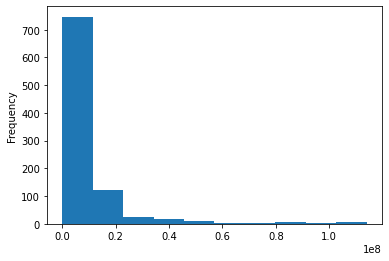

In [10]:
df_celeb.followers_count.plot.hist()

In [68]:
df_celeb.drop(["domain", "type"], axis=1).to_csv("../data/celebrity/enhanced_1k_celebrities.csv", index=False)

## Enhance with Tweet Counts API results

In [11]:
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
from api.twitter import fetch_historical_counts

def get_query_for_username(username):
    return f"@{username} OR from:{username} OR to:{username}"

def get_tweet_counts_by_username(username):
    start_time = datetime.strptime(
        "2021-01-01", 
        '%Y-%m-%d'
    )
    end_time = start_time + relativedelta(months=3)

    granularity = "day" # hour

    return fetch_historical_counts({
        "query": get_query_for_username(username),
        "start_time": datetime.combine(
            start_time,
            datetime.min.time()
        ).replace(tzinfo=timezone.utc).isoformat(),
        "end_time": datetime.combine(
            end_time,
            datetime.min.time()
        ).replace(tzinfo=timezone.utc).isoformat(),
        "granularity": granularity
    })

In [12]:
tweet_count_data_by_user = {}

In [34]:
import time

i = 0
for user in df_celeb_raw.twitter.sort_values():
    if (i < 300):
        try:
            if user not in tweet_count_data_by_user:
                i += 1
                tweet_count_data_by_user[user] = get_tweet_counts_by_username(user)
        except:
            print(f"Rate limited for {user}, waiting 15 sec..")
            time.sleep(15)

In [35]:
len(tweet_count_data_by_user)

986

In [36]:
import pickle

# Safety for not overriding the cache with an empty dict...
if (len(tweet_count_data_by_user) >= 986):
    with open("../data/celebrity/tweet_count_data_by_user", "wb") as f:
        pickle.dump(tweet_count_data_by_user, f)

In [41]:
import pickle
with open("../data/celebrity/tweet_count_data_by_user", "rb") as f:
    cached_tweet_count_data_by_user = pickle.load(f)
len(cached_tweet_count_data_by_user)

986

In [92]:
df_celeb = pd.read_csv("../data/celebrity/enhanced_1k_celebrities.csv")
df_celeb["query_tweet_count"] = df_celeb.twitter_username.apply(
    lambda u: cached_tweet_count_data_by_user[u]["meta"]["total_tweet_count"]
)
df_celeb

,twitter_username,name,followers_count,user_tweet_count,created_at,id,query_tweet_count
0,katyperry,KATY PERRY,108789024,11460,2009-02-20T23:45:56.000Z,21447363,748786
1,justinbieber,Justin Bieber,114060688,31380,2009-03-28T16:41:22.000Z,27260086,4589799
2,taylorswift13,Taylor Swift,88903543,691,2008-12-06T10:10:54.000Z,17919972,4375820
3,rihanna,Rihanna,103256018,10587,2009-10-02T21:37:33.000Z,79293791,2893095
4,ladygaga,Lady Gaga,83801008,9645,2008-03-26T22:37:48.000Z,14230524,1546900
...,...,...,...,...,...,...,...
934,Zedd,Zedd,7742802,34966,2010-06-14T21:53:37.000Z,155705264,44148
935,SleepintheGardn,Troian,2349183,8321,2010-04-08T23:29:12.000Z,130991061,5632
936,therealjuicyj,juicy j,2795518,46484,2009-03-13T22:59:30.000Z,24275419,83570
937,manugavassi,Manu Gavassi,6433461,42676,2009-04-15T22:44:52.000Z,31547933,169243


In [201]:
# Drop non-celeb account
df_celeb = df_celeb[df_celeb.followers_count > 1000].drop_duplicates("twitter_username")
df_celeb.reset_index(drop=True).sort_values("query_tweet_count", ascending=False)

,twitter_username,name,followers_count,user_tweet_count,created_at,id,query_tweet_count
702,elonmusk,Elon Musk,61115743,15714,2009-06-02T20:12:29.000Z,44196397,14968780
34,Louis_Tomlinson,Louis Tomlinson,35939242,7564,2009-10-22T08:58:11.000Z,84279963,11279933
19,Harry_Styles,Harry Styles.,37010333,5581,2010-08-22T14:19:06.000Z,181561712,6283104
56,BeingSalmanKhan,Salman Khan,43043216,43028,2010-04-13T02:56:21.000Z,132385468,5416612
1,justinbieber,Justin Bieber,114060688,31380,2009-03-28T16:41:22.000Z,27260086,4589799
...,...,...,...,...,...,...,...
282,Angelluisr,Angel Rivera,1127856,8428,2009-02-10T04:02:59.000Z,20490840,23
566,BRUNOIERULLO,BRUNO IERULLO,956975,1025,2009-04-07T12:59:13.000Z,29441764,11
892,bonnovanderputt,bonno van der putten,436268,26581,2012-01-28T17:27:40.000Z,476946794,9
848,siyovushdustov,Siyovush Dustov,418448,3,2012-02-28T06:59:04.000Z,507005731,3


In [203]:
df_celeb.to_csv("../data/celebrity/enhanced_1k_celebrities.csv", index=False)

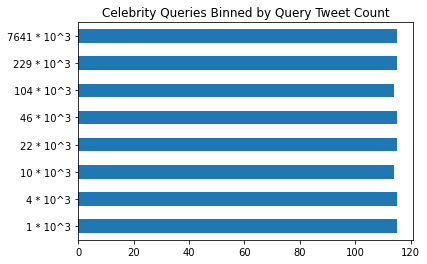

In [194]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
out = pd.qcut(
    df_celeb.query_tweet_count, 
    q=8
)
ax = out.value_counts(sort=False).plot.barh(rot=0, figsize=(6,4))
ax.set_yticklabels([str(int(c.mid / 1000)) + " * 10^3" for c in out.cat.categories])
plt.title("Celebrity Queries Binned by Query Tweet Count")
plt.show()

In [242]:
from utils.label_spikes import timeseries_from_query_counts

get_timeseries = timeseries_from_query_counts
rihanna_timeseries = get_timeseries(cached_tweet_count_data_by_user["rihanna"])
rihanna_timeseries

,tweet_count
time_end,
2021-01-02 00:00:00+00:00,34871
2021-01-03 00:00:00+00:00,29705
2021-01-04 00:00:00+00:00,5130
2021-01-05 00:00:00+00:00,4462
2021-01-06 00:00:00+00:00,3339
...,...
2021-03-28 00:00:00+00:00,11538
2021-03-29 00:00:00+00:00,4551
2021-03-30 00:00:00+00:00,5687


In [191]:
import plotly.express as px

px.line(rihanna_timeseries.tweet_count)

In [273]:
from utils.label_spikes import detect_anomalies
from merlion.transform.moving_average import MovingAverage
from merlion.post_process.threshold import Threshold
from merlion.models.anomaly.forecast_based.prophet import ProphetDetectorConfig, ProphetDetector

prophet_config = ProphetDetectorConfig(
    threshold=Threshold(alm_threshold=0.5),
    #transform=MovingAverage(n_steps=1),
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    add_seasonality=True,  
    uncertainty_samples=1000
)

df_scores, df_labels, plot = anomaly_scores = detect_anomalies(
    rihanna_timeseries, 
    "tweet_count",
    model=ProphetDetector(prophet_config),
)
plot.show()


Initial log joint probability = -52.164
Iteration  1. Log joint probability =    88.8234. Improved by 140.987.
Iteration  2. Log joint probability =    108.412. Improved by 19.5887.
Iteration  3. Log joint probability =    113.778. Improved by 5.36642.
Iteration  4. Log joint probability =    113.837. Improved by 0.0581746.
Iteration  5. Log joint probability =    113.883. Improved by 0.0467115.
Iteration  6. Log joint probability =    113.921. Improved by 0.0379321.
Iteration  7. Log joint probability =    113.932. Improved by 0.0108165.
Iteration  8. Log joint probability =    113.969. Improved by 0.0365996.
Iteration  9. Log joint probability =    113.987. Improved by 0.0182486.
Iteration 10. Log joint probability =    114.059. Improved by 0.0719874.
Iteration 11. Log joint probability =    114.076. Improved by 0.0169669.
Iteration 12. Log joint probability =    114.098. Improved by 0.022149.
Iteration 13. Log joint probability =    114.122. Improved by 0.0238892.
Iteration 14. Log

In [241]:
def count_spikes(df_labels, anom_score_cutoff):
    anoms = pd.DataFrame(df_labels.anom_score > anom_score_cutoff).astype(int)
    anoms["reset"] = anoms.anom_score == 0
    anoms["consecutive_sum"] = anoms.groupby(anoms["reset"].cumsum())["anom_score"].cumsum()
    

    return (anoms["consecutive_sum"] == 1).sum()

print("--Consecutive spikes--")
for threshold in [0.5, 1, 2, 3]:
    print(f"Anomaly score > {threshold}: {count_spikes(df_labels, threshold)}")

--Consecutive spikes--
Anomaly score > 0.5: 19
Anomaly score > 1: 10
Anomaly score > 2: 1
Anomaly score > 3: 1


In [ ]:
detected_spikes_by_user = {}
ANOMALY_THRESHOLDS = [0.5, 1, 2, 3]
for username in df_celeb.twitter_username:
    if username not in detected_spikes_by_user:
        df_timeseries = get_timeseries(cached_tweet_count_data_by_user[username])
        
        df_scores, df_labels = anomaly_scores = detect_anomalies(
            df_timeseries, 
            "tweet_count",
            model=ProphetDetector(prophet_config),
            plot=False
        )
        detected_spikes = {}
        
        for threshold in [0.5, 1, 2, 3]:
            detected_spikes[threshold] = count_spikes(df_labels, threshold)
        detected_spikes_by_user[username] = detected_spikes


In [255]:
for threshold in ANOMALY_THRESHOLDS:
    col = f"spikes_above_{threshold}"
    df_celeb[col] = df_celeb.twitter_username.apply(
        lambda u: detected_spikes_by_user[u][threshold]
    )

df_celeb

,twitter_username,name,followers_count,user_tweet_count,created_at,id,query_tweet_count,spikes_above_0.5,spikes_above_1,spikes_above_2,spikes_above_3
0,katyperry,KATY PERRY,108789024,11460,2009-02-20T23:45:56.000Z,21447363,748786,22,11,1,1
1,justinbieber,Justin Bieber,114060688,31380,2009-03-28T16:41:22.000Z,27260086,4589799,18,14,3,0
2,taylorswift13,Taylor Swift,88903543,691,2008-12-06T10:10:54.000Z,17919972,4375820,25,13,3,1
3,rihanna,Rihanna,103256018,10587,2009-10-02T21:37:33.000Z,79293791,2893095,18,10,1,1
4,ladygaga,Lady Gaga,83801008,9645,2008-03-26T22:37:48.000Z,14230524,1546900,19,10,2,2
...,...,...,...,...,...,...,...,...,...,...,...
933,kylieminogue,Kylie Minogue,2199320,14025,2009-08-05T16:03:32.000Z,63172203,105694,21,14,2,0
934,Zedd,Zedd,7742802,34966,2010-06-14T21:53:37.000Z,155705264,44148,21,11,3,1
935,SleepintheGardn,Troian,2349183,8321,2010-04-08T23:29:12.000Z,130991061,5632,21,10,2,0
936,therealjuicyj,juicy j,2795518,46484,2009-03-13T22:59:30.000Z,24275419,83570,23,14,3,1


In [266]:
df_celeb.sort_values("query_tweet_count", ascending=False).to_csv("../data/celebrity/enhanced_1k_celebrities_with_spikes.csv", index=False)

In [267]:
df_celeb_with_spikes = pd.read_csv("../data/celebrity/enhanced_1k_celebrities_with_spikes.csv")

In [272]:
px.scatter(
    x=df_celeb_with_spikes.query_tweet_count,
    y=df_celeb_with_spikes.spikes_above_1,
    title="Number of spikes with anomaly score above 1 vs. query tweet count"
)